# Exploring the Design Space
Here, we will demonstrate how to use TimeloopFE to conduct design space explorations
with Timeloop & Accelergy. We will use TimeloopFE to launch Timeloop+Accelergy jobs,
then gather the results from each.

In this design space exploration, we will use a simple architecture with a DRAM, a
global buffer, and an array of PEs which each have a register and a compute unit. We
will vary the number of PEs and the global buffer size.

We start by defining a `run_test` function that takes in a scale factor for the
global buffer size and a scale factor for the number of PEs. The function will
run the Timeloop mapper and return the global buffer size, number of PEs, and
energy in pJ/MAC.


In [84]:
import pytimeloop.timeloopfe.v4 as tl
import os

def run_test(path_to_problem, path_to_arch, path_to_mapping):
    # Get the specification from yaml files
    spec = tl.Specification.from_yaml_files(path_to_problem, path_to_arch, path_to_mapping)

    # Give each run a unique ID and run the mapper
    proc_id = f"layer={path_to_problem}"
    out_dir = f"{os.curdir}/outputs/{proc_id}"

    return (
        spec.architecture.find("GlobalBuffer"),
        tl.call_mapper(spec, output_dir=out_dir, log_to=f"{out_dir}/output.log"),
    )


Rather than run each test sequentially in a `for` loop, we can use the joblib library
to multiprocess our calls and speed up design space exploration.


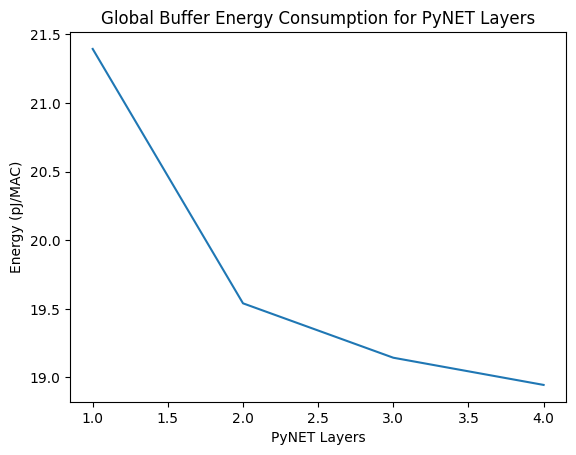

In [85]:
import shutil
import matplotlib.pyplot as plt

PyNET_Layers_specification = [[f"{os.curdir}/inputs/PyNET_Layer1/problem.yaml", f"{os.curdir}/inputs/PyNET_Layer1/arch.yaml", f"{os.curdir}/inputs/PyNET_Layer1/mapper.yaml"],
                              [f"{os.curdir}/inputs/PyNET_Layer2/problem.yaml", f"{os.curdir}/inputs/PyNET_Layer2/arch.yaml", f"{os.curdir}/inputs/PyNET_Layer2/mapper.yaml"],
                              [f"{os.curdir}/inputs/PyNET_Layer3/problem.yaml", f"{os.curdir}/inputs/PyNET_Layer3/arch.yaml", f"{os.curdir}/inputs/PyNET_Layer3/mapper.yaml"],
                              [f"{os.curdir}/inputs/PyNET_Layer4/problem.yaml", f"{os.curdir}/inputs/PyNET_Layer4/arch.yaml", f"{os.curdir}/inputs/PyNET_Layer4/mapper.yaml"]]

results = joblib.Parallel(n_jobs=None)(
    joblib.delayed(run_test)(*layer) for layer in PyNET_Layers_specification
)

layers = list(range(1, len(PyNET_Layers_specification) + 1))
energies = [r[1].per_compute("energy") * 1e12 for r in results]

plt.plot(layers, energies)
plt.xlabel('PyNET Layers')
plt.ylabel('Energy (pJ/MAC)')
plt.title('Global Buffer Energy Consumption for PyNET Layers')
plt.show()